In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.datasets import make_moons, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from joblib import dump, load

from skorch import NeuralNetClassifier

%matplotlib inline

# Sonar Dataset

In [3]:
X = pd.read_csv('/home/nareg/Desktop/DataScience/Deep_Learning/sonar.all-data', header = None,
                usecols = range(0, 60))

y = pd.read_csv('/home/nareg/Desktop/DataScience/Deep_Learning/sonar.all-data', header = None,
                usecols = [60])

y = pd.Series(y.values.ravel()).map({'M': 1, 'R': 0})


In [4]:
print(X.shape)
X.head(3)

(208, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078


In [5]:
#imp = SimpleImputer(missing_values = 'NaN', strategy = 'mean', axis = 0)   
#pca = PCA()

#steps = [('imputation', imp), ('logistic_regression', logreg)]

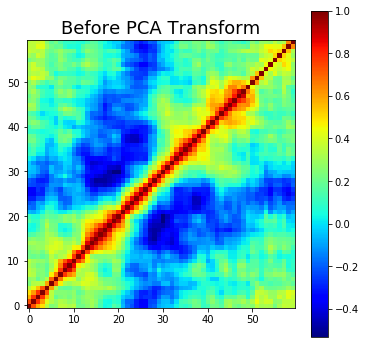

In [6]:
plt.figure(figsize = (6, 6))

plt.imshow(X.corr().values, origin = 'lower', cmap = 'jet')

plt.title("Before PCA Transform", size = 18)
plt.colorbar();

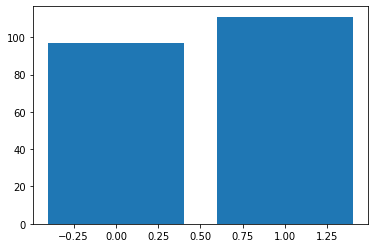

In [7]:
# Labels are balanced
plt.bar(pd.value_counts(y.values.ravel()).index, pd.value_counts(y.values.ravel()));

In [8]:
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X), index = X.index)

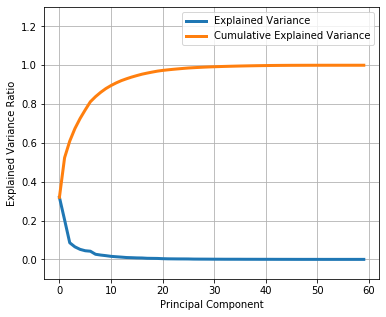

In [9]:
plt.figure(figsize = (6, 5))

plt.plot(pca.explained_variance_ratio_, lw = 3, label = 'Explained Variance')
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw = 3, label = 'Cumulative Explained Variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.ylim(-0.1, 1.3)
plt.grid();

In [10]:
# Where we pass 90% explained
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

16

In [11]:
X_ = X_pca.iloc[:, 0:16]

print(X_.shape)
X_.head()

(208, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.576093,0.319393,-0.387291,-0.378009,-0.243780,-0.156243,-0.427736,0.074832,-0.024347,0.318054,0.115546,-0.191408,-0.235610,-0.176814,-0.229228,-0.045350
1,-0.970667,1.018039,0.834156,0.107423,0.286070,0.178684,-0.260332,0.385600,-0.004030,-0.072529,0.194461,-0.188529,-0.055020,-0.099839,0.130939,0.069038
2,-0.325887,0.874209,0.246015,0.863031,0.069110,-0.300833,-0.412807,0.075321,-0.010855,-0.438559,0.154054,-0.017024,-0.076625,0.292401,0.152490,0.016435
3,0.852035,0.690863,-0.013390,-0.110257,-0.554050,0.397968,0.492569,-0.220460,0.537003,-0.436795,-0.336882,0.241950,0.074977,-0.108527,-0.132554,-0.004814
4,-0.064756,0.222968,0.638601,0.140432,0.135854,0.052881,-0.386558,0.066549,-0.117006,-0.419277,0.145586,-0.394497,0.186196,0.022140,-0.120318,-0.220539


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_.values.astype(np.float32), y.values.astype(np.int64), test_size = 0.25)

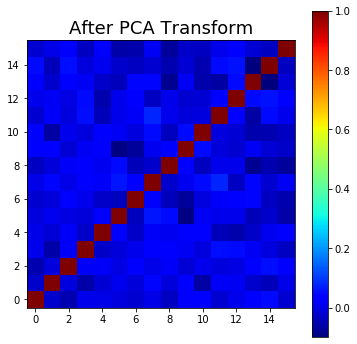

In [13]:
plt.figure(figsize = (6, 6))

plt.imshow(pd.DataFrame(X_train).corr().values, origin = 'lower', cmap = 'jet')

plt.title("After PCA Transform", size = 18)
plt.colorbar();

In [20]:
class dNet(nn.Module):
    
    
    def __init__(self, n_hidden1 = 100, n_hidden2 = 100):
        
        super(dNet, self).__init__()
        
        self.dense1 = nn.Linear(16, n_hidden1)   # hidden layer
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(n_hidden1, n_hidden2)
        self.dense3 = nn.Linear(n_hidden2, 2)           # output layer
        
        # do not need softmax layer when using CEloss criterion ?
        self.softmax = nn.Softmax(dim = 1)
                
  
    def forward(self, x):
        
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.dense3(x)
        x = self.softmax(x)
    
        return x
    

In [21]:
X_train.shape

(156, 16)

In [22]:
net = NeuralNetClassifier(dNet,
                          max_epochs = 20,
                          lr = 0.01,
                          # Shuffle training data on each epoch
                          iterator_train__shuffle = True,
                          verbose = 1,
                          optimizer = torch.optim.Adam)

net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6923       0.5625        0.6814  0.0085
      2        0.6526       0.5938        0.6691  0.0066
      3        0.6056       0.5625        0.6571  0.0075
      4        0.5466       0.6250        0.6453  0.0055
      5        0.4803       0.6250        0.6354  0.0044
      6        0.4124       0.6875        0.6342  0.0054
      7        0.3500       0.6562        0.6553  0.0038
      8        0.2995       0.6562        0.6847  0.0039
      9        0.2602       0.7188        0.6967  0.0043
     10        0.2264       0.7188        0.6957  0.0069
     11        0.1969       0.7188        0.6979  0.0086
     12        0.1678       0.7812        0.7012  0.0069
     13        0.1370       0.7812        0.7078  0.0073
     14        0.1094       0.7812        0.7287  0.0073
     15        0.0869       0.8125        0.7610  0.0085
     16        0.0675       0.8

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=dNet(
    (dense1): Linear(in_features=16, out_features=100, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=100, out_features=100, bias=True)
    (dense3): Linear(in_features=100, out_features=2, bias=True)
    (softmax): Softmax(dim=1)
  ),
)

In [23]:
y_pred = net.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1])

In [24]:
np.mean(y_pred == y_test)

0.8846153846153846

# GridSearchCV

In [26]:
net.set_params(train_split = False, verbose = 0)

params = {
          'lr': [1e-5, 1e-3, 0.1],
          'max_epochs': [50, 1_500],
          'module__n_hidden1': [25, 100],
          'module__n_hidden2': [25, 100]
         }

gs = GridSearchCV(net, params, refit = False, cv = 5, scoring = 'accuracy', verbose = 2)

# CV is important bc dataset is small no validation

In [27]:
gs.fit(X_train, y_train)

print(f"best score:, {gs.best_score_}, best params: { gs.best_params_}.")
#print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25, total=   0.3s
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25, total=   0.2s
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25 
[CV]  lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25, total=   0.3s
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25 
[CV]  lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25, total=   0.2s
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25 
[CV]  lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=25, total=   0.2s
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=100 
[CV]  lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=100, total=   0.2s
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=100 
[CV]  lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=100, total=   0.2s
[CV] lr=1e-05, max_epochs=50, module__n_hidden1=25, module__n_hidden2=100 
[CV]  lr=1e-05, m

[CV]  lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=25, total=   0.2s
[CV] lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=25 
[CV]  lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=25, total=   0.2s
[CV] lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=25 
[CV]  lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=25, total=   0.3s
[CV] lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=25 
[CV]  lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=25, total=   0.2s
[CV] lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=100 
[CV]  lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=100, total=   0.3s
[CV] lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=100 
[CV]  lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=100, total=   0.3s
[CV] lr=0.001, max_epochs=50, module__n_hidden1=100, module__n_hidden2=100 
[CV] 

[CV]  lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=25, total=  17.0s
[CV] lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=25 
[CV]  lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=25, total=  16.9s
[CV] lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=25 
[CV]  lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=25, total=  17.0s
[CV] lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=25 
[CV]  lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=25, total=  16.8s
[CV] lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=100 
[CV]  lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=100, total=  17.0s
[CV] lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=100 
[CV]  lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=100, total=  16.9s
[CV] lr=0.1, max_epochs=1500, module__n_hidden1=25, module__n_hidden2=100 
[CV]  lr=0.1, max

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 22.0min finished


In [32]:
net_best = NeuralNetClassifier(dNet, module__n_hidden1 = 100, module__n_hidden2 = 25,
                          max_epochs = 1_500,
                          lr = 0.001,
                          # Shuffle training data on each epoch
                          iterator_train__shuffle = True,
                          verbose = 1,
                          optimizer = torch.optim.Adam)

net_best.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6918       0.5000        0.6939  0.0036
      2        0.6894       0.5312        0.6935  0.0046
      3        0.6871       0.5312        0.6930  0.0053
      4        0.6850       0.5312        0.6926  0.0041
      5        0.6829       0.5312        0.6923  0.0038
      6        0.6808       0.5312        0.6919  0.0045
      7        0.6787       0.5312        0.6914  0.0041
      8        0.6764       0.5312        0.6910  0.0043
      9        0.6742       0.5312        0.6908  0.0041
     10        0.6720       0.5312        0.6906  0.0042
     11        0.6697       0.5312        0.6904  0.0049
     12        0.6674       0.5312        0.6902  0.0053
     13        0.6650       0.5312        0.6900  0.0046
     14        0.6625       0.5312        0.6897  0.0043
     15        0.6599       0.5312        0.6893  0.0086
     16        0.6572       0.5

    111        0.1347       0.6875        0.6675  0.0047
    112        0.1317       0.6875        0.6694  0.0044
    113        0.1287       0.6875        0.6712  0.0042
    114        0.1257       0.6875        0.6730  0.0032
    115        0.1228       0.7188        0.6748  0.0034
    116        0.1200       0.7188        0.6768  0.0031
    117        0.1171       0.7188        0.6790  0.0031
    118        0.1144       0.7500        0.6812  0.0034
    119        0.1117       0.7500        0.6834  0.0034
    120        0.1090       0.7500        0.6856  0.0033
    121        0.1064       0.7500        0.6878  0.0036
    122        0.1038       0.7500        0.6900  0.0035
    123        0.1013       0.7500        0.6923  0.0036
    124        0.0988       0.7500        0.6947  0.0045
    125        0.0964       0.7500        0.6971  0.0050
    126        0.0941       0.7500        0.6994  0.0091
    127        0.0917       0.7500        0.7017  0.0064
    128        0.0895       0.7

    235        0.0098       0.8125        1.0010  0.0039
    236        0.0096       0.8125        1.0035  0.0039
    237        0.0095       0.8125        1.0060  0.0040
    238        0.0094       0.8125        1.0085  0.0062
    239        0.0092       0.8125        1.0109  0.0067
    240        0.0091       0.8125        1.0134  0.0065
    241        0.0090       0.8125        1.0158  0.0040
    242        0.0089       0.8125        1.0182  0.0039
    243        0.0088       0.8125        1.0206  0.0060
    244        0.0087       0.8125        1.0229  0.0053
    245        0.0085       0.8125        1.0252  0.0044
    246        0.0084       0.8125        1.0274  0.0054
    247        0.0083       0.8125        1.0298  0.0038
    248        0.0082       0.8125        1.0321  0.0040
    249        0.0081       0.8125        1.0344  0.0093
    250        0.0080       0.8125        1.0368  0.0079
    251        0.0079       0.8125        1.0390  0.0049
    252        0.0078       0.8

    360        0.0029       0.8125        1.2246  0.0088
    361        0.0029       0.8125        1.2260  0.0050
    362        0.0028       0.8125        1.2274  0.0048
    363        0.0028       0.8125        1.2288  0.0036
    364        0.0028       0.8125        1.2302  0.0031
    365        0.0028       0.8125        1.2315  0.0038
    366        0.0028       0.8125        1.2329  0.0033
    367        0.0027       0.8125        1.2342  0.0031
    368        0.0027       0.8125        1.2355  0.0037
    369        0.0027       0.8125        1.2369  0.0035
    370        0.0027       0.8125        1.2382  0.0034
    371        0.0027       0.8125        1.2396  0.0062
    372        0.0027       0.8125        1.2410  0.0053
    373        0.0026       0.8125        1.2423  0.0083
    374        0.0026       0.8125        1.2437  0.0103
    375        0.0026       0.8125        1.2450  0.0097
    376        0.0026       0.8125        1.2463  0.0095
    377        0.0026       0.8

    485        0.0014       0.8125        1.3655  0.0042
    486        0.0014       0.8125        1.3664  0.0061
    487        0.0014       0.8125        1.3673  0.0066
    488        0.0014       0.8125        1.3682  0.0071
    489        0.0014       0.8125        1.3692  0.0041
    490        0.0014       0.8125        1.3701  0.0036
    491        0.0013       0.8125        1.3711  0.0034
    492        0.0013       0.8125        1.3720  0.0035
    493        0.0013       0.8125        1.3729  0.0042
    494        0.0013       0.8125        1.3738  0.0036
    495        0.0013       0.8125        1.3747  0.0037
    496        0.0013       0.8125        1.3756  0.0039
    497        0.0013       0.8125        1.3765  0.0036
    498        0.0013       0.8125        1.3775  0.0046
    499        0.0013       0.8125        1.3784  0.0055
    500        0.0013       0.8125        1.3793  0.0096
    501        0.0013       0.8125        1.3802  0.0063
    502        0.0013       0.8

    610        0.0008       0.8125        1.4640  0.0070
    611        0.0008       0.8125        1.4647  0.0058
    612        0.0008       0.8125        1.4653  0.0068
    613        0.0008       0.8125        1.4660  0.0062
    614        0.0008       0.8125        1.4667  0.0069
    615        0.0008       0.8125        1.4673  0.0049
    616        0.0008       0.8125        1.4679  0.0059
    617        0.0008       0.8125        1.4686  0.0045
    618        0.0008       0.8125        1.4693  0.0048
    619        0.0008       0.8125        1.4699  0.0044
    620        0.0008       0.8125        1.4706  0.0047
    621        0.0008       0.8125        1.4713  0.0053
    622        0.0008       0.8125        1.4719  0.0052
    623        0.0008       0.8125        1.4725  0.0049
    624        0.0008       0.8125        1.4732  0.0049
    625        0.0008       0.8125        1.4738  0.0062
    626        0.0008       0.8125        1.4744  0.0046
    627        0.0008       0.8

    735        0.0005       0.8125        1.5364  0.0044
    736        0.0005       0.8125        1.5369  0.0056
    737        0.0005       0.8125        1.5374  0.0046
    738        0.0005       0.8125        1.5379  0.0062
    739        0.0005       0.8125        1.5384  0.0058
    740        0.0005       0.8125        1.5389  0.0046
    741        0.0005       0.8125        1.5394  0.0072
    742        0.0005       0.8125        1.5399  0.0098
    743        0.0005       0.8125        1.5404  0.0054
    744        0.0005       0.8125        1.5409  0.0049
    745        0.0005       0.8125        1.5414  0.0045
    746        0.0005       0.8125        1.5419  0.0052
    747        0.0005       0.8125        1.5424  0.0047
    748        0.0005       0.8125        1.5429  0.0051
    749        0.0005       0.8125        1.5434  0.0047
    750        0.0005       0.8125        1.5439  0.0047
    751        0.0005       0.8125        1.5443  0.0053
    752        0.0005       0.8

    860        0.0004       0.8125        1.5911  0.0060
    861        0.0004       0.8125        1.5915  0.0073
    862        0.0004       0.8125        1.5919  0.0050
    863        0.0004       0.8125        1.5923  0.0040
    864        0.0004       0.8125        1.5927  0.0048
    865        0.0004       0.8125        1.5931  0.0046
    866        0.0004       0.8125        1.5934  0.0040
    867        0.0004       0.8125        1.5938  0.0055
    868        0.0004       0.8125        1.5942  0.0050
    869        0.0004       0.8125        1.5946  0.0046
    870        0.0004       0.8125        1.5949  0.0049
    871        0.0004       0.8125        1.5953  0.0056
    872        0.0004       0.8125        1.5957  0.0066
    873        0.0004       0.8125        1.5960  0.0072
    874        0.0004       0.8125        1.5964  0.0054
    875        0.0004       0.8125        1.5968  0.0162
    876        0.0004       0.8125        1.5971  0.0048
    877        0.0004       0.8

    985        0.0003       0.8125        1.6331  0.0071
    986        0.0003       0.8125        1.6334  0.0053
    987        0.0003       0.8125        1.6337  0.0053
    988        0.0003       0.8125        1.6340  0.0040
    989        0.0003       0.8125        1.6343  0.0046
    990        0.0003       0.8125        1.6346  0.0038
    991        0.0003       0.8125        1.6349  0.0050
    992        0.0003       0.8125        1.6352  0.0051
    993        0.0003       0.8125        1.6354  0.0041
    994        0.0003       0.8125        1.6357  0.0040
    995        0.0003       0.8125        1.6360  0.0040
    996        0.0003       0.8125        1.6363  0.0038
    997        0.0003       0.8125        1.6366  0.0051
    998        0.0003       0.8125        1.6369  0.0054
    999        0.0003       0.8125        1.6372  0.0060
   1000        0.0003       0.8125        1.6375  0.0042
   1001        0.0003       0.8125        1.6378  0.0055
   1002        0.0003       0.8

   1110        0.0002       0.8125        1.6665  0.0068
   1111        0.0002       0.8125        1.6667  0.0046
   1112        0.0002       0.8125        1.6670  0.0047
   1113        0.0002       0.8125        1.6672  0.0071
   1114        0.0002       0.8125        1.6674  0.0090
   1115        0.0002       0.8125        1.6677  0.0097
   1116        0.0002       0.8125        1.6679  0.0080
   1117        0.0002       0.8125        1.6682  0.0050
   1118        0.0002       0.8125        1.6684  0.0061
   1119        0.0002       0.8125        1.6686  0.0044
   1120        0.0002       0.8125        1.6689  0.0050
   1121        0.0002       0.8125        1.6691  0.0057
   1122        0.0002       0.8125        1.6694  0.0045
   1123        0.0002       0.8125        1.6696  0.0044
   1124        0.0002       0.8125        1.6698  0.0045
   1125        0.0002       0.8125        1.6701  0.0071
   1126        0.0002       0.8125        1.6703  0.0046
   1127        0.0002       0.8

   1235        0.0002       0.8125        1.6940  0.0055
   1236        0.0002       0.8125        1.6942  0.0061
   1237        0.0002       0.8125        1.6944  0.0049
   1238        0.0002       0.8125        1.6946  0.0039
   1239        0.0002       0.8125        1.6948  0.0048
   1240        0.0002       0.8125        1.6949  0.0035
   1241        0.0002       0.8125        1.6951  0.0049
   1242        0.0002       0.8125        1.6953  0.0040
   1243        0.0002       0.8125        1.6955  0.0059
   1244        0.0002       0.8125        1.6957  0.0033
   1245        0.0002       0.8125        1.6959  0.0044
   1246        0.0002       0.8125        1.6961  0.0036
   1247        0.0002       0.8125        1.6963  0.0051
   1248        0.0002       0.8125        1.6965  0.0035
   1249        0.0002       0.8125        1.6967  0.0037
   1250        0.0002       0.8125        1.6969  0.0040
   1251        0.0002       0.8125        1.6971  0.0044
   1252        0.0002       0.8

   1360        0.0001       0.8125        1.7168  0.0048
   1361        0.0001       0.8125        1.7169  0.0050
   1362        0.0001       0.8125        1.7171  0.0041
   1363        0.0001       0.8125        1.7173  0.0049
   1364        0.0001       0.8125        1.7174  0.0042
   1365        0.0001       0.8125        1.7176  0.0053
   1366        0.0001       0.8125        1.7178  0.0047
   1367        0.0001       0.8125        1.7179  0.0041
   1368        0.0001       0.8125        1.7181  0.0087
   1369        0.0001       0.8125        1.7183  0.0103
   1370        0.0001       0.8125        1.7184  0.0043
   1371        0.0001       0.8125        1.7186  0.0043
   1372        0.0001       0.8125        1.7188  0.0064
   1373        0.0001       0.8125        1.7189  0.0037
   1374        0.0001       0.8125        1.7191  0.0044
   1375        0.0001       0.8125        1.7193  0.0039
   1376        0.0001       0.8125        1.7194  0.0041
   1377        0.0001       0.8

   1485        0.0001       0.8125        1.7363  0.0044
   1486        0.0001       0.8125        1.7364  0.0044
   1487        0.0001       0.8125        1.7366  0.0075
   1488        0.0001       0.8125        1.7367  0.0071
   1489        0.0001       0.8125        1.7369  0.0041
   1490        0.0001       0.8125        1.7370  0.0042
   1491        0.0001       0.8125        1.7372  0.0044
   1492        0.0001       0.8125        1.7373  0.0069
   1493        0.0001       0.8125        1.7374  0.0090
   1494        0.0001       0.8125        1.7376  0.0043
   1495        0.0001       0.8125        1.7377  0.0071
   1496        0.0001       0.8125        1.7379  0.0152
   1497        0.0001       0.8125        1.7380  0.0045
   1498        0.0001       0.8125        1.7382  0.0053
   1499        0.0001       0.8125        1.7383  0.0050
   1500        0.0001       0.8125        1.7385  0.0054


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=dNet(
    (dense1): Linear(in_features=16, out_features=100, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=100, out_features=25, bias=True)
    (dense3): Linear(in_features=25, out_features=2, bias=True)
    (softmax): Softmax(dim=1)
  ),
)

In [33]:
dump(net_best, 'net_best_estimator.pkl')

['net_best_estimator.pkl']

In [34]:
y_pred3 = net_best.predict(X_test)
print(f"Accuracy: {np.mean(y_pred3 == y_test)}")

Accuracy: 0.8653846153846154


In [60]:
pd.DataFrame(confusion_matrix(y_pred.ravel(), y_test),
             index = ['R', 'M'], columns = ['R', 'M'])

,R,M
R,21,1
M,3,27


In [49]:
false_pos_rate, true_pos_rate, _ = roc_curve(y_pred.ravel(), y_test)
roc_auc = auc(false_pos_rate, true_pos_rate)

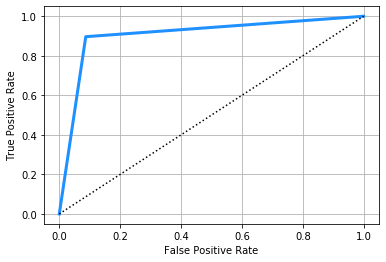

In [50]:
plt.plot(false_pos_rate, true_pos_rate, label = 'ROC curve (Area = %0.2f)' % roc_auc,
         lw = 3, color = 'dodgerblue')

plt.plot([0, 1], [0, 1], 'k:')

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

---

# KNN

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.33, random_state = 420)

In [104]:
X_train.shape

(139, 12)

In [105]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [106]:
knn.score(X_test, y_test)

0.8260869565217391

In [111]:
y_pred_knn = knn.predict(X_test)

In [112]:
np.mean(y_pred_knn == y_test.values)

0.8260869565217391

In [113]:
knn.classes_

array([0, 1])

In [114]:
pd.DataFrame(confusion_matrix(y_test, y_pred_knn), index = ['R', 'M'], columns = ['R', 'M'])

,R,M
R,30,3
M,9,27


# SVM


In [21]:
svc = SVC(C = 10.0, kernel = 'rbf', gamma = 2)
svc.fit(X_train, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
svc.score(X_test, y_test)

0.8260869565217391

In [23]:
y_pred_knn = svc.predict(X_test)

In [24]:
pd.DataFrame(confusion_matrix(y_test, y_pred_knn), index = ['R', 'M'], columns = ['R', 'M'])

,R,M
R,25,8
M,4,32
